# Usage example on model of _Corynebacterium tuberculostearicum (high GC Gram+)_.
In this notebook we show how to use the Mass Charge Curation python package. As an example model we use a model of [_Corynebacterium tuberculostearicum (high GC Gram+)_, strain DSM 44922](https://www.ncbi.nlm.nih.gov/assembly/GCF_013408445.1/) created with [CarveMe Version 1.5.1](https://carveme.readthedocs.io/en/latest/index.html), which here is simply called _model.xml_.

If you are interested in a more verbose output you can uncomment the following line:

In [1]:
import logging; logging.basicConfig(format='%(levelname)s: %(filename)s %(lineno)d, %(funcName)s: %(message)s', level=logging.INFO) 

## Dependencies
First we will check if all dependencies of the curation package are fullfilled.

In [2]:
try: import numpy
except Exception as e: print("You seem to be missing numpy. You can usually install it via 'pip install numpy'"); raise e
try: import pandas
except Exception as e: print("You seem to be missing pandas. You can usually install it via 'pip install pandas'"); raise e
try: import requests
except Exception as e: print("You seem to be missing requests. You can usually install it via 'pip install requests'"); raise e
try: import matplotlib
except Exception as e: print("You seem to be missing matplotlib. You can usually install it via 'pip install matplotlib'"); raise e
try: import z3
except Exception as e: print("You seem to be missing z3 or the corresponding python bindings. See https://github.com/Z3Prover/z3 on how to install it."); raise e

Next we see if the Mass Charge Curation package is installed properly.

In [3]:
try: import MCC
except Exception as e: print("The mass charge curation package does not seem to be installed correctly. Make sure you have the correct python version installed and try running pip install -e ./.. in the folder of this notebook."); raise e

## Setting input path
We can use the package with different type of models. Depending on what else we intend to do with the model we can already read it in using libsbml or cobraPy or immediatly pass in the path of the model (This will cause the module to read it in itself using libsbml).

In [4]:
model = "model.xml"

# Alternatives:
# reading in the model beforehand using libsbml:
'''
import libsbml
reader = libsbml.SBMLReader()
document = reader.readSBML(model)
model = document.getModel()
'''
# reading in the model beforehand using cobraPy:
'''
import cobra
model = cobra.io.read_sbml_model(model)
'''
print(model)

model.xml


## Basic Model Information
First we can take a quick look at the model using the module ModelInterface class:

In [5]:
mi = MCC.ModelInterface(model)
print(f"The model has {len(mi.metabolites)} metabolites and {len(mi.reactions)} reactions.")
unbalanced_reactions = [r_id for r_id, r in mi.reactions.items() if (not r.is_balanced())]
print(f"There are {len(unbalanced_reactions)} unbalanced reactions with {len(mi.get_pseudo_reactions())} pseudo reactions.")

The model has 1019 metabolites and 1481 reactions.
There are 446 unbalanced reactions with 196 pseudo reactions.


## Curating Mass and Charge
We can now instantiate a curation class. There are different ways to use the package, depending how data should be gathered, how much curation has already been done and how much data is available offline.

We will first give an example of the most simple usage, downloading as many databases as possible and updating all [identifiers.org](https://identifiers.org/) identifiers we need for the package to work optimally. This will take significantly longer (**~ 15 Minutes**) than running the algorithm on an already annotated model, however it is important to use the most up-to-date identifiers if we want to include as much information as possible.

This will create a folder _/data_ in the current directory where all database information is downloaded to.

The arguments are as follows:
* **model**: Model we want to curate.
* **data_path**: Path to the directory containing database files. Defaults to _/data_. If the directory does not exist, it will be created. If a file cannot be found, we will try to download it. 
* **update_ids**: If this is set to _True_, we will first try to update all [identifiers.org](https://identifiers.org/) ids. This will take a while but is important to properly index the different databases. Defaults to _False_. 

**Note**: It is expected to see _No objective coefficients in model. Unclear what should be optimized_ warnings here, this poses no problem for this package.

In [6]:
balancer = MCC.MassChargeCuration(model = model, data_path = "./data", run_optimization = True, update_ids = True)

INFO: DataCollection.py 182, get_all_ids: 1/1019: M_10fthf_c
INFO: DataCollection.py 226, get_ids: Found new ids ['10fthf'] in bigg.metabolite via id & name based search for M_10fthf_c
INFO: DataCollection.py 182, get_all_ids: 2/1019: M_12dgr140_c
INFO: DataCollection.py 226, get_ids: Found new ids ['12dgr140'] in bigg.metabolite via id & name based search for M_12dgr140_c
INFO: DataCollection.py 182, get_all_ids: 3/1019: M_12dgr140_p
INFO: DataCollection.py 226, get_ids: Found new ids ['12dgr140'] in bigg.metabolite via id & name based search for M_12dgr140_p
INFO: DataCollection.py 182, get_all_ids: 4/1019: M_12dgr141_c
INFO: DataCollection.py 226, get_ids: Found new ids ['12dgr141'] in bigg.metabolite via id & name based search for M_12dgr141_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM4940 in metanetx.chemical from ('bigg.metabolite', '12dgr141') for M_12dgr141_c
INFO: DataCollection.py 182, get_all_ids: 5/1019: M_12dgr141_p
INFO: DataCollection.py 226, get_ids: Found 

## Evaluating the result
To see the results at a first glance, we can generate a quick visual report, which tells us how many reactions are balanced now, and how many assignments were changed.

<ipython-input-7-45868f457808>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  balancer.generate_visual_report().show()


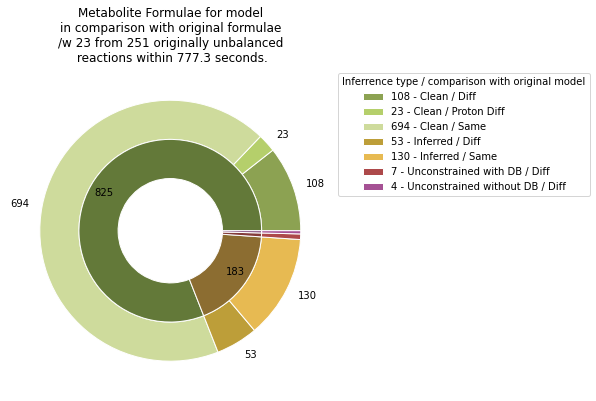

In [7]:
balancer.generate_visual_report().show()

### Metabolite Report
The algorithm should be able to give a reason for every assignment that it chooses. We can have a look at these reasons in the metabolite report of the balancer.

The report holds valuable information how the algorithm decided which assignment to choose and can be useful during further manual curation. The entries of the resulting DataFrame are the following:
* **Id**: Id of the metabolite in the model.
* **Name**: Name of the metabolite in the model.
* **Determined Formula**: Formula that was assigned by the algorithm.
* **Determined Charge**: Charge that was assigned by the algorithm.
* **Previous Formula**: Formula that was assigned before the algorithm.
* **Previous Charge**: Charge that was assigned before the algorithm.
* **Inferrence Type**: Category of how the assignment was determined.
    - Unconstrained: No information about the metabolite was found or only incomplete (wildcard containing) formulae were found and we could not find a concrete formula either. Should contain a wildcard.
    - Inferred: No information about the metabolite was found or only incomplete (wildcard containing formulae were found, however we arrived at a concrete formula. Should not contain a wildcard.
    - Clean: Information about the metabolite was found and used.
* **Reasoning**: Reasoning how the assignment was determined. Can contain:
    - database name:database identifier: The formula could be found in this database under this identifier.
    - (unconstrained) Target: This assignment was chosen because it is the same as in the original (target) model. Unconstrained means that the original (target) model seemed to be missing a wildcard symbol that was thus added.
    - Reaction_id (metabolite id -> Reasoning...): The assignment for this metabolite must follow from other reasons. The given reaction id and metabolite reasons make it so that if the model must be balanced, this metabolite must have the determined assignment.
    - Used Databases: The databases which back up the determined assignment.
    - Previous Databases: The databases which back up the previous assignment.

In [8]:
metabolite_report_df = balancer.generate_metabolite_report()
metabolite_report_df[::200]

,Id,Name,Determined Formula,Determined Charge,Previous Formula,Previous Charge,Inferrence Type,Reasoning,Used Databases,Previous Databases,Similarity
0,M_12dgr140_c,"1,2-Diacyl-sn-glycerol (ditetradecanoyl, n-C14:0)",C31H60O5,0,C31H60O5,0,Inferred,unconstrained Target & Adherence,,,Same
200,M_12dgr180_c,"1,2-Diacyl-sn-glycerol (dioctadecanoyl, n-C18:0)",C39H76O5,0,C39H76O5,0,Clean,unconstrained Target & Adherence & metanetx.ch...,metanetx.chemical:MNXM4217,metanetx.chemical:MNXM4217,Same
400,M_3mb_e,3-Methylbutanoic acid,C5H9O2,-1,C5H9O2,-1,Clean,unconstrained Target & Adherence & seed.compou...,"seed.compound:cpd05178, metanetx.chemical:MNXM...","seed.compound:cpd05178, metanetx.chemical:MNXM...",Same
600,M_hmbil_c,Hydroxymethylbilane,C40H38N4O17,-8,C40H38N4O17,-8,Clean,unconstrained Target & Adherence & metanetx.ch...,"metanetx.chemical:MNXM547, seed.compound:cpd00755","metanetx.chemical:MNXM547, seed.compound:cpd00755",Same
800,M_gln__L_c,L-Glutamine,C5H10N2O3,0,C5H10N2O3,0,Clean,unconstrained Target & Adherence & seed.compou...,"seed.compound:cpd00053, seed.compound:cpd00253...","seed.compound:cpd00053, seed.compound:cpd00253...",Same
1000,M_pa181_c,"1,2-dioctadec-11-enoyl-sn-glycerol 3-phosphate",C39H72O8P,-1,C39H71O8P,0,Clean,"metanetx.chemical:MNXM90511, seed.compound:cpd...","metanetx.chemical:MNXM90511, seed.compound:cpd...",,Diff


Usually we are interested in the assignments which differ from the original report. We can do this by indexing the Dataframe accordingly.

In [9]:
# If you like to see the entire report, uncomment the following line
#pandas.set_option("display.max_row", None)
metabolite_report_df[metabolite_report_df["Similarity"] != "Same"]

,Id,Name,Determined Formula,Determined Charge,Previous Formula,Previous Charge,Inferrence Type,Reasoning,Used Databases,Previous Databases,Similarity
130,M_R_3hhxa_e,3 hydroxyhexanoic acid,C6H12O3,0,C6H11O3,0,Inferred,,,,Diff
131,M_R_3hhxa_p,3 hydroxyhexanoic acid,C6H12O3,0,C6H11O3,0,Inferred,,,,Diff
132,M_abg4_e,4-aminobenzoate-glutamate,C12H14N2O5,0,C12H11N2O5,0,Inferred,,,,Diff
133,M_glyglu_e,L glycinylglutamate,C7H12N2O5,0,C7H11N2O5,0,Inferred,,,,Diff
134,M_glyglu_p,L glycinylglutamate,C7H12N2O5,0,C7H11N2O5,0,Inferred,,,,Diff
...,...,...,...,...,...,...,...,...,...,...,...
1014,M_aso3_c,Arsenite,AsH2O3,-1,AsH3O3,0,Clean,"seed.compound:cpd26385, metanetx.chemical:MNXM...","seed.compound:cpd26385, metanetx.chemical:MNXM...",,Proton Diff
1015,M_aso3_e,Arsenite,AsH2O3,-1,AsH3O3,0,Clean,"seed.compound:cpd26385, metanetx.chemical:MNXM...","seed.compound:cpd26385, metanetx.chemical:MNXM...",,Proton Diff
1016,M_aso3_p,Arsenite,AsH2O3,-1,AsH3O3,0,Clean,"seed.compound:cpd26385, metanetx.chemical:MNXM...","seed.compound:cpd26385, metanetx.chemical:MNXM...",,Proton Diff
1017,M_h2s_c,Hydrogen sulfide,HS,-1,H2S,0,Clean,"seed.compound:cpd24697, seed.compound:cpd00239...","seed.compound:cpd24697, seed.compound:cpd00239...",,Proton Diff


We might also be interested in all assignments which are not backed by a database:

In [10]:
metabolite_report_df[metabolite_report_df["Used Databases"] == ""]

,Id,Name,Determined Formula,Determined Charge,Previous Formula,Previous Charge,Inferrence Type,Reasoning,Used Databases,Previous Databases,Similarity
0,M_12dgr140_c,"1,2-Diacyl-sn-glycerol (ditetradecanoyl, n-C14:0)",C31H60O5,0,C31H60O5,0,Inferred,unconstrained Target & Adherence,,,Same
1,M_12dgr140_p,"1,2-Diacyl-sn-glycerol (ditetradecanoyl, n-C14:0)",C31H60O5,0,C31H60O5,0,Inferred,unconstrained Target & Adherence,,,Same
2,M_1ag160_e,1 Acyl sn glycerol hexadecanoate,C19H38O4,0,C19H38O4,0,Inferred,unconstrained Target & Adherence,,,Same
3,M_1ag180_e,1 Acyl sn glycerol octadecanoate,C21H42O4,0,C21H42O4,0,Inferred,unconstrained Target & Adherence,,,Same
4,M_1ag181d9_e,1 Acyl sn glycerol nC181d9,C21H40O4,0,C21H40O4,0,Inferred,unconstrained Target & Adherence,,,Same
...,...,...,...,...,...,...,...,...,...,...,...
182,M_ficytc_c,Ferricytochrome c C42H52FeN8O6S2,C34FeH32N4O42,-1,C33FeH31N4O4,0,Inferred,R_CYO1b: (M_h2o_c -> Adherence & seed.compound...,,,Diff
186,M_dhlpro_c,Dihydrolipolprotein H2S2X,C14H16N3O52R,0,C8H16NOS2,0,Unconstrained,R_GCCc: (M_h_c -> Adherence & metanetx.chemica...,,,Diff
187,M_glutrna_c,L-Glutamyl-tRNA(Glu),C33H41N12O24P3R,0,C33H41N12O24P3,0,Unconstrained,unconstrained Target & R_GLUTRS_2: (M_amp_c ->...,,,Diff
191,M_alpro_c,S Aminomethyldihydrolipoylprotein CH6NS2X,C15H20N4O52R,1,C9H20N2OS2,0,Unconstrained,R_GCCa: (M_co2_c -> Adherence & seed.compound:...,,,Diff


### Reaction Report
Finally, especially for further curation, we might be interested in the remaining imbalanced reactions. For this the algorithm can also provide a report.

The report also includes reactions which are technically balanced but where many protons had to be added to arrive at that result.

The fields are as follows:
* **Id**: Id of the reaction in the model.
* **Unbalanced Reaction**: Name of the reaction in the model and corresponding equation.
* **Unbalanced Type**: Type of imbalance. Can be both Mass and charge, only mass, only charge or high proton count.
* **Reason**: Set of reactions which caused the reaction to be imbalanced. This effectively means that these reactions could not be balanced together. The sets are minimal, but for example for BTS2, it would not help to remove HCYSMT, as BTS2 would require protons to have no charge and HCYSMT is only one of many reactions which then would not be balanced.
* **Shared Metabolites**: Metabolites which are shared between the reactions which are listed in Reason. Can give an indication where the problem might lie.
* **Mass Difference**: Mass imbalance.
* **Charge Difference**: Charge imbalance.

In [11]:
balancer.generate_reaction_report()

,Id,Unbalanced Reaction,Unbalanced Type,Reason,Shared Metabolites,Mass Difference,Charge Difference
0,R_CMCBTFL,"Reaction(id='R_CMCBTFL', name='CMCBTFL', metab...","Mass, Charge",R_CMCBTFL,"M_fe3_e, M_cmcbtt_c, M_fcmcbtt_c","Fe: -1.0, H: -2.0",-3.0
1,R_CMCBTFU,"Reaction(id='R_CMCBTFU', name='CMCBTFU', metab...","Mass, Charge",R_CMCBTFU,"M_fe3_c, M_cmcbtt_c, M_fcmcbtt_c, M_h_c","H: 3.0, Fe: 1.0",4.0
2,R_CYO1_KT,"Reaction(id='R_CYO1_KT', name='Ubiquinol cyt...","Mass, Charge",R_CYO1_KT,"M_q8h2_c, M_q8_c, M_h_c, M_ficytc_c, M_h_p, M_...","C: -2.0, H: -2.0, O: -76.0",6.0
3,R_CYO1b,"Reaction(id='R_CYO1b', name='CYO1b', metabolit...","Mass, Charge",R_CYO1b,"M_ficytc_c, M_h2o_c, M_focytc_c, M_o2_c","C: 2.0, H: 2.0, O: 76.0",-6.0
4,R_FCLT2,"Reaction(id='R_FCLT2', name='FCLT2', metabolit...","Mass, Charge",R_FCLT2,"M_pheme_c, M_h_c, M_ppp9_c, M_mcbtt_c, M_fmcbtt_c","H: 6.0, C: 4.0",-2.0
5,R_FE3DCITabc,"Reaction(id='R_FE3DCITabc', name='Iron transpo...","Mass, Charge",R_FE3DCITabc,"M_adp_c, M_fe3_c, M_fe3dcit_e, M_pi_c, M_h2o_c...",H: -11.0,-2.0
6,R_FETRANS,"Reaction(id='R_FETRANS', name='FETRANS', metab...","Mass, Charge",R_FETRANS,"M_mcbtt_c, M_fmcbtt_c, M_fe2_c","C: 4.0, H: 6.0",-2.0
7,R_NMO,"Reaction(id='R_NMO', name='Nitronate Monooxyge...","Mass, Charge",R_NMO,"M_acald_c, M_fmnh2_c, M_h_c, M_fmn_c, M_etha_c...",H: 2.0,6.0
8,R_CREAT,"Reaction(id='R_CREAT', name='Creatinase', meta...",Mass,R_CREAT,"M_h2o_c, M_creat_c, M_sarcs_c, M_urea_c","H: 2.0, O: 1.0",0.0
9,R_MCBTS3,"Reaction(id='R_MCBTS3', name='MCBTS3', metabol...",Mass,R_MCBTS3,"M_salc_c, M_pi_c, M_nadph_c, M_co2_c, M_atp_c,...",O: -1.0,0.0


### Writing Files
The mass charge curation writes directly to the model that was given to it. Thus, if we want to write our model, we can just pass the model to cobrapy. If you want to keep your old model, you should make sure to not overwrite it here.

In [12]:
balancer.model_interface.write_model("model_MCC.xml")

For the reports, we can add filenames to the functions to write the visual report to a .png file and the metabolite and reaction DataFrames to .csv files.

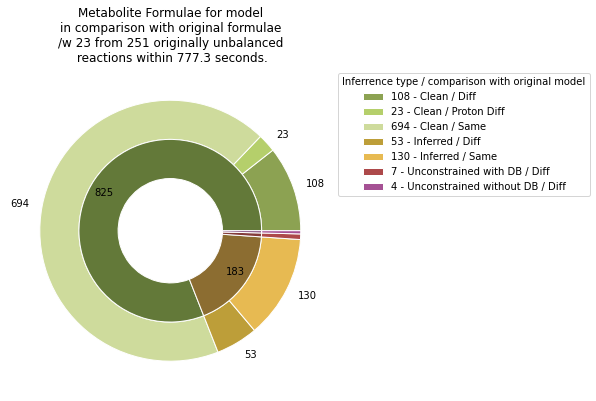

In [14]:
balancer.generate_visual_report(f"{model}_visual")
balancer.generate_metabolite_report(f"{model}_metabolites")
balancer.generate_reaction_report(f"{model}_reactions")
pass

## Fixing Assignments
For some metabolites we might want to fix their assignment, based on some knowledge that is not encoded in the used databases or is not used as it will yield a (theoretically) suboptimal result. We can do this by passing a dictionary mapping the metabolites id to the fixed assignment. If, for example, we want the metabolite with the id "M_h2o_c" to have the certain formula "CO2" and charge of 5 and the metabolite with the id "M_h_c" have a formula of "C5" and a charge of -7, we can tell this to our algorithm in the following way:

In [15]:
fixed_assignments = {"M_h2o_c" : ("CO2", 5), "M_h_c" : ("C5", -7)}
balancer = MCC.MassChargeCuration(model = model, data_path = "./data", run_optimization = True, update_ids = False, fixed_assignments = fixed_assignments)

INFO: DataCollection.py 141, gather_info: 1/1019: Getting information for M_10fthf_c
INFO: DataCollection.py 141, gather_info: 2/1019: Getting information for M_12dgr140_c
INFO: DataCollection.py 141, gather_info: 3/1019: Getting information for M_12dgr140_p
INFO: DataCollection.py 141, gather_info: 4/1019: Getting information for M_12dgr141_c
INFO: DataCollection.py 141, gather_info: 5/1019: Getting information for M_12dgr141_p
INFO: DataCollection.py 141, gather_info: 6/1019: Getting information for M_12dgr160_c
INFO: DataCollection.py 141, gather_info: 7/1019: Getting information for M_12dgr160_e
INFO: DataCollection.py 141, gather_info: 8/1019: Getting information for M_12dgr160_p
INFO: DataCollection.py 141, gather_info: 9/1019: Getting information for M_12dgr180_c
INFO: DataCollection.py 141, gather_info: 10/1019: Getting information for M_12dgr180_e
INFO: DataCollection.py 141, gather_info: 11/1019: Getting information for M_12dgr180_p
INFO: DataCollection.py 141, gather_info: 1

In [16]:
unbalanced_reactions = [r_id for r_id, r in balancer.model_interface.reactions.items() if (not r.is_balanced())]
print(f"There are {len(unbalanced_reactions)} unbalanced reactions with {len(balancer.model_interface.get_pseudo_reactions())} pseudo reactions.")

There are 963 unbalanced reactions with 196 pseudo reactions.


In [17]:
balancer.model_interface.metabolites["M_h2o_c"]

Metabolite(id='M_h2o_c', name='H2O H2O', formula=CO2, charge=5, SBO=247)

In [18]:
balancer.model_interface.metabolites["M_h_c"]

Metabolite(id='M_h_c', name='H+', formula=C5, charge=-7, SBO=247)

We can see that setting strange values for water and hydrogen will make many reactions unbalancable but that the balancer adheres to the fixed values.

## Using BioCyc flat files
If you have access (currently requires an explicit academic license or a subscription) and downloaded the BioCyc flat files, you can pass the corresponding directory as well. Assuming we have already updated all the ids in the last step, we can set _update_ids_ to _False_.

The additional argument is:
* **biocyc_path**: Directory containing BioCyc flat files.

In [ ]:
balancer = MCC.MassChargeCuration(model = model, data_path = "./data", update_ids = True, biocyc_path = "./data/23.5/data")